In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [4]:
# Loading in new (revised) data
file_path_trainC = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx"
train_cat = pd.read_excel(file_path_trainC)

file_path_trainFCM = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
train_FCM = pd.read_csv(file_path_trainFCM)

file_path_trainQ = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx"
train_Quant = pd.read_excel(file_path_trainQ)

file_path_trainS = file_path_trainQ = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx"
train_Solutions = pd.read_excel(file_path_trainS)

**Pre-Processing**

In [8]:
# Set up for one hot encoding
for col in train_cat.select_dtypes(include='int').columns:
    train_cat[col] = train_cat[col].astype('category')

In [10]:
# Creating a list of all of the columns except the first
columns_to_encode = train_cat.columns[1:].tolist()

# Print the columns to encode
print("Columns to encode:", columns_to_encode)

Columns to encode: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']


In [12]:
# encoding categorical data
train_encoded = pd.get_dummies(train_cat[columns_to_encode], drop_first=True)
train_encoded = train_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/2479499898.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_encoded = train_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [14]:
print(train_cat.columns)

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')


In [16]:
columns_to_encode

['Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'MRI_Track_Scan_Location',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ']


KeyError: "['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ'] 

In [19]:
# Combine encoded columns with the rest of the DataFrame
cat_train_final = pd.concat([train_cat.drop(columns=columns_to_encode), train_encoded], axis=1)

# ensure it looks correct
cat_train_final.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4
0,00aIpNTbG5uh,1.0,0.0,3.0,21.0,45.0,NaN,NaN,0,0,0,1,0,0,0,1
1,00fV0OyyoLfw,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0,1,0,0,0,0,0,0
2,04X1eiS79T4B,1.0,2.0,2.0,9.0,0.0,NaN,NaN,0,1,0,0,0,0,0,0
3,05ocQutkURd6,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,0,1,0,0,0,0,0
4,06YUNBA9ZRLq,0.0,1.0,2.0,12.0,0.0,NaN,NaN,0,0,1,0,0,0,0,0


**Train and Test Dataframes**

In [22]:
# load in test categorical dataframe

file_path_testC = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TEST/TEST_CATEGORICAL.xlsx"
test_cat = pd.read_excel(file_path_testC)
test_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0


In [24]:
# convert our int variables to categories
for col in test_cat.select_dtypes(include='int').columns:
    test_cat[col] = test_cat[col].astype('category')

# Encode categorical variables in test
test_encoded = pd.get_dummies(test_cat[columns_to_encode], drop_first=True)
test_encoded = test_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Ensure test_encoded has the same columns as train_encoded
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0  # Add missing columns with 0 values

# Ensure test_encoded columns are in the same order as train_encoded
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Combine encoded columns with the rest of the DataFrame
cat_test_final = pd.concat([test_cat.drop(columns=columns_to_encode), test_encoded], axis=1)

cat_test_final.head()

/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/2044556609.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_encoded = test_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))


,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4
0,Cfwaf5FX7jWK,0.0,0.0,0,21.0,30.0,18.0,30.0,0,0,0,0,0,0,0,0
1,vhGrzmvA3Hjq,0.0,0.0,0,21.0,45.0,NaN,30.0,0,0,0,0,0,0,0,0
2,ULliyEXjy4OV,0.0,0.0,0,21.0,40.0,18.0,40.0,0,0,0,0,0,0,0,0
3,LZfeAb1xMtql,0.0,0.0,0,21.0,45.0,21.0,45.0,0,0,0,0,0,0,0,0
4,EnFOUv0YK1RG,2.0,0.0,0,18.0,0.0,21.0,45.0,0,0,0,0,0,0,0,0


**Merging Data Frames**

In [27]:
train_cat_FCM = pd.merge(cat_train_final, train_FCM, on = 'participant_id')

In [29]:
train_df = pd.merge(train_cat_FCM, train_Quant, on = 'participant_id')

train_df.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,1.0,0.0,3.0,21.0,45.0,NaN,NaN,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0,1,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,1.0,2.0,2.0,9.0,0.0,NaN,NaN,0,1,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,0,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.0,1.0,2.0,12.0,0.0,NaN,NaN,0,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


**Merge test dataframes**

In [31]:
file_path_testFCM = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_FCM = pd.read_csv(file_path_testFCM)

file_path_testQ = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_Quant = pd.read_excel(file_path_testQ)

test_cat_FCM = pd.merge(cat_test_final, test_FCM, on = 'participant_id')

test_df = pd.merge(test_cat_FCM, test_Quant, on = 'participant_id')

# ensure it looks accurate
test_df.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,0.0,0.0,0,21.0,30.0,18.0,30.0,0,0,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,0.0,0.0,0,21.0,45.0,NaN,30.0,0,0,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,0.0,0.0,0,21.0,40.0,18.0,40.0,0,0,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,0.0,0.0,0,21.0,45.0,21.0,45.0,0,0,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,2.0,0.0,0,18.0,0.0,21.0,45.0,0,0,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


In [32]:
len(test_df.columns)

19934

## NA Values

First, we will check to see how many null values we have, sorted by most to least.

In [38]:
# check how many NA values we have
print(train_df.isna().sum().sort_values(ascending=False))

MRI_Track_Age_at_Scan               360
Barratt_Barratt_P2_Occ              222
Barratt_Barratt_P2_Edu              198
PreInt_Demos_Fam_Child_Race          54
PreInt_Demos_Fam_Child_Ethnicity     43
                                   ... 
36throw_134thcolumn                   0
36throw_133thcolumn                   0
36throw_132thcolumn                   0
36throw_131thcolumn                   0
58throw_121thcolumn                   0
Length: 19934, dtype: int64


From this, we can see that the columns, MRI_Track_Age_at_Scan, Barratt_Barratt_P2_Occ, and Barratt_Barratt_P2 Edu have the most null values. Next, we will check to see which of the columns correlate most with our labels (sex and ADHD)

In [41]:
corr_df = train_df.merge(train_Solutions, on = 'participant_id')
corr_matrix = corr_df.drop('participant_id', axis=1).corr()
top_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))\
                            .stack()\
                            .sort_values(ascending=False)
print(top_corr)

18throw_26thcolumn    18throw_129thcolumn     0.945837
26throw_121thcolumn   121throw_129thcolumn    0.944378
16throw_26thcolumn    16throw_129thcolumn     0.938968
26throw_120thcolumn   120throw_129thcolumn    0.936229
14throw_26thcolumn    14throw_129thcolumn     0.934782
                                                ...   
145throw_184thcolumn  184throw_185thcolumn   -0.622788
87throw_99thcolumn    99throw_141thcolumn    -0.629990
39throw_99thcolumn    88throw_99thcolumn     -0.639167
42throw_184thcolumn   184throw_185thcolumn   -0.640044
88throw_99thcolumn    99throw_141thcolumn    -0.668734
Length: 198692145, dtype: float64


In [43]:
cols_with_null = train_df.columns[train_df.isna().any()]
len(cols_with_null)

25

In [45]:
corr_df = corr_matrix[cols_with_null]

In [47]:
corr_df.head()

,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
PreInt_Demos_Fam_Child_Ethnicity,1.000000,0.347621,-0.059821,-0.151631,-0.071257,-0.170385,-0.172485,-0.013564,0.031756,0.025207,...,0.021134,0.025475,0.028328,-0.003650,0.014427,-0.020743,0.051469,0.056993,0.047233,0.021263
PreInt_Demos_Fam_Child_Race,0.347621,1.000000,0.037278,-0.040573,-0.059814,-0.080915,-0.056446,-0.037751,-0.018730,0.080683,...,-0.009259,-0.006729,-0.001397,-0.022854,-0.015936,-0.026971,0.014278,0.025378,0.036501,0.067621
MRI_Track_Scan_Location,-0.059821,0.037278,1.000000,0.170834,0.061553,0.178037,0.141151,0.037695,0.031196,-0.066889,...,-0.064943,-0.052507,-0.092600,0.021500,0.037577,0.078602,-0.122708,-0.110206,-0.011616,-0.004967
Barratt_Barratt_P1_Edu,-0.151631,-0.040573,0.170834,1.000000,0.391740,0.366556,0.272463,0.058907,0.011693,-0.061348,...,-0.056986,-0.105335,-0.083812,-0.049843,-0.013985,-0.032280,-0.136717,-0.142870,0.034975,-0.051131
Barratt_Barratt_P1_Occ,-0.071257,-0.059814,0.061553,0.391740,1.000000,0.093194,0.054059,0.043687,-0.001132,-0.071751,...,-0.034678,-0.040305,-0.069579,-0.002450,-0.024018,0.021433,-0.072128,-0.048974,0.043143,0.014106


In [49]:
# largest_value_a = corr_df.drop('PreInt_Demos_Fam_Child_Ethnicity')['PreInt_Demos_Fam_Child_Ethnicity'].max()
# largest_value_a
list_can_predict = []
for col in cols_with_null:
    largest_value = corr_df.drop(col)[col].max()
    smallest_value = corr_df.drop(col)[col].min()
    if largest_value > 0.5:
        print(col, largest_value)
        prediction_pair = (str(corr_df[corr_df[col] == largest_value].index[0]), col)
        print(prediction_pair)
        list_can_predict.append(prediction_pair)
        print('')
    elif smallest_value < -0.5:
        print(col, smallest_value)
        prediction_pair = (str(corr_df[corr_df[col] == smallest_value].index[0]), col)
        print(prediction_pair)
        list_can_predict.append(prediction_pair)
        print('')

MRI_Track_Scan_Location -0.6029508181435435
('Basic_Demos_Enroll_Year_2016', 'MRI_Track_Scan_Location')

Barratt_Barratt_P2_Edu 0.556523658384038
('Barratt_Barratt_P2_Occ', 'Barratt_Barratt_P2_Edu')

Barratt_Barratt_P2_Occ 0.556523658384038
('Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ')

APQ_P_APQ_P_INV 0.5634624027018682
('APQ_P_APQ_P_PP', 'APQ_P_APQ_P_INV')

APQ_P_APQ_P_PM 0.5695162275906511
('MRI_Track_Age_at_Scan', 'APQ_P_APQ_P_PM')

APQ_P_APQ_P_PP 0.5634624027018682
('APQ_P_APQ_P_INV', 'APQ_P_APQ_P_PP')

SDQ_SDQ_Conduct_Problems 0.7942472498319892
('SDQ_SDQ_Externalizing', 'SDQ_SDQ_Conduct_Problems')

SDQ_SDQ_Difficulties_Total 0.8769288389024463
('SDQ_SDQ_Externalizing', 'SDQ_SDQ_Difficulties_Total')

SDQ_SDQ_Emotional_Problems 0.8318512282680854
('SDQ_SDQ_Internalizing', 'SDQ_SDQ_Emotional_Problems')

SDQ_SDQ_Externalizing 0.8990330623789716
('SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Externalizing')

SDQ_SDQ_Generating_Impact 0.7126223524536951
('SDQ_SDQ_Difficulties_Total', 'SDQ_

From this information, we can see that some columns correlate heavily with each other, so we can build a simple linear regression model to predict the null values. We will make a function that does this.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
def linear_regression_for_nulls(feature_col, label_col):
    # Accessing all rows where label_col is null, will predict with this data
    rows_with_null_label = train_df[train_df[label_col].isna()]
    # rows_with_null_test = test_df[test_df[label_col].isna()]
    
    # Creating training dataset to predict null values

    # Dataframe without null values in label column
    train_label_df = train_df[~train_df.index.isin(rows_with_null_label.index)].drop('participant_id', axis=1)

    # Fill in other null columns with mean
    target_column = label_col

    # Calculate the mean of the column 'feature_col' (ignores NaN values automatically)
    mean_value = train_df[feature_col].mean()
    
    # Fill NaN values in 'feature_col' with the mean
    train_label_df[feature_col] = train_label_df[feature_col].fillna(mean_value)
    rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
    # rows_with_null_test[feature_col] = rows_with_null_test[feature_col].fillna(mean_value)

    # Prepare the data (X is feature column, y is label column)
    X = train_label_df[[feature_col]]  # Feature columns (make sure it's a 2D array)
    y = train_label_df[label_col]      # Label column
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the linear regression model
    model = LinearRegression()
    
    # Train the model using the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    new_vals = model.predict(rows_with_null_label[[feature_col]])
    # new_vals_test = model.predict(rows_with_null_test[[feature_col]])
    # return (new_vals, new_vals_test)
    return new_vals

In [56]:
# linear_regression_for_nulls('Basic_Demos_Enroll_Year_2016', 'MRI_Track_Scan_Location')

In [57]:
train_df.isna().sum().sum()

1115

In [58]:
print(len(list_can_predict))

15


In [59]:
# for pair in list_can_predict:
#     new_vals = linear_regression_for_nulls(pair[0], pair[1])
#     train_df.loc[train_df[pair[1]].isna(), pair[1]] = new_vals
#     print(train_df.isna().sum().sum())
for pair in list_can_predict:
    # Get the predicted values using your function
    new_vals = linear_regression_for_nulls(pair[0], pair[1])
    # new_vals = result[0]
    # new_vals_test = result[1]
    train_df.loc[train_df[pair[1]].isna(), pair[1]] = new_vals
    # test_df.loc[test_df[pair[1]].isna(), pair[1]] = new_vals_test
    
    # Print the number of remaining NaN values after updating
    print(train_df.isna().sum().sum())

1112


/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:

914
692
680


/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:

668
656
647


/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:

638
629
620


/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:

611
602
593
584
224


/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null_label[feature_col] = rows_with_null_label[feature_col].fillna(mean_value)
/var/folders/xs/50kmp8g92x99q2dxvv031c980000gn/T/ipykernel_34616/490833609.py:

In [60]:
train_df.isna().sum().sum()

224

In [61]:
# remember to do the same for the testing data!

In [62]:
train_df.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,1.0,0.0,3.0,21.0,45.0,16.86762,30.582819,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,0.0,9.0,2.0,21.0,0.0,21.00000,45.000000,0,1,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,15.262711
2,04X1eiS79T4B,1.0,2.0,2.0,9.0,0.0,16.86762,30.582819,0,1,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,3.0,8.0,2.0,18.0,10.0,18.00000,0.000000,0,0,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.0,1.0,2.0,12.0,0.0,16.86762,30.582819,0,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [63]:
train_df.isna().sum()

participant_id                       0
PreInt_Demos_Fam_Child_Ethnicity    43
PreInt_Demos_Fam_Child_Race         54
MRI_Track_Scan_Location              0
Barratt_Barratt_P1_Edu              15
                                    ..
SDQ_SDQ_Hyperactivity                0
SDQ_SDQ_Internalizing                0
SDQ_SDQ_Peer_Problems                0
SDQ_SDQ_Prosocial                    9
MRI_Track_Age_at_Scan                0
Length: 19934, dtype: int64

In [67]:
# # fill NA values using the mean
# train_df.fillna({'MRI_Track_Age_at_Scan':train_df['MRI_Track_Age_at_Scan'].mean()}, inplace = True)
# train_df.fillna({'PreInt_Demos_Fam_Child_Ethnicity':train_df['PreInt_Demos_Fam_Child_Ethnicity'].mean()}, inplace = True)

# print(train_df.isna().sum().sum())

In [68]:
# Using backward and foward fills (indicates using previous or the following data row in order to replace the missing values)
# I think this shouldn't do anything because above shows that there are no more null values
train_df.ffill(inplace = True)
print(train_df.isna().sum().sum())

0


In [69]:
# Fill NAs of test data

for col in test_df.columns:
    if test_df[col].isna().sum() > 0:  # Check if the column has NaN values
        if test_df[col].dtype in ['float64', 'int64']:  # Ensure it's numeric
            test_df[col] = test_df[col].fillna(test_df[col].mean())  # Avoid inplace
        else:
            print(f"Skipping non-numeric column: {col}")

In [70]:
test_df.isna().sum().sum()

0

In [71]:
train_df.to_csv('/Users/mayapatel/UCLA_WiDs_Team-21/train-edited2.csv', index=False)
test_df.to_csv('/Users/mayapatel/UCLA_WiDs_Team-21/test-edited2.csv', index=False)

## Machine Learning

In [78]:
file_path_trainS = "/Users/mayapatel/UCLA_WiDs_Team-21/data/TRAIN/TRAINING_SOLUTIONS.xlsx"
train_Solutions = pd.read_excel(file_path_trainS)

In [79]:
X_train = train_df.drop(columns = ['participant_id'])
Y_train = train_Solutions.drop(columns = ['participant_id'])

In [80]:
Y_train.head()

,ADHD_Outcome,Sex_F
0,1,1
1,1,0
2,1,0
3,1,1
4,1,1


In [81]:
# Step 1: Ensure that 'adhd' and 'sex' are in the Y_train DataFrame
Y_train = train_Solutions[['ADHD_Outcome', 'Sex_F']]  # Assuming 'adhd' and 'sex' are in train_Solutions

# Step 2: Calculate correlations between each feature in X_train and the target columns in Y_train
correlations = {}

for target_column in Y_train.columns:  # Loop over each target column ('adhd' and 'sex')
    corr_with_target = X_train.corrwith(Y_train[target_column])  # Calculate correlation with target column
    correlations[target_column] = corr_with_target  # Store the correlations for each target

# Step 3: Combine the results into a single DataFrame
correlations_df = pd.DataFrame(correlations)

# Step 4: Sort the correlations for both columns ('adhd' and 'sex') and find the top 20 features
# Combine both columns into a single list and get the top 20 correlated features
top_20_features = pd.concat([correlations_df['ADHD_Outcome'], correlations_df['Sex_F']], axis=1)

# Sort by the absolute correlation value and pick top 20
top_20_features = top_20_features.abs().mean(axis=1).sort_values(ascending=False).head(20)

# Print top 20 correlated features
print(top_20_features)

51throw_129thcolumn     0.096815
142throw_168thcolumn    0.091926
45throw_174thcolumn     0.087388
50throw_83thcolumn      0.084712
138throw_183thcolumn    0.083787
26throw_51thcolumn      0.082540
117throw_150thcolumn    0.081433
149throw_174thcolumn    0.077518
47throw_174thcolumn     0.076885
36throw_55thcolumn      0.075060
73throw_78thcolumn      0.074631
121throw_181thcolumn    0.074003
44throw_174thcolumn     0.073936
68throw_97thcolumn      0.073629
48throw_77thcolumn      0.073593
129throw_171thcolumn    0.073017
45throw_173thcolumn     0.072398
48throw_174thcolumn     0.072362
75throw_152thcolumn     0.072352
27throw_146thcolumn     0.072177
dtype: float64


In [82]:
correlations_df.head()

,ADHD_Outcome,Sex_F
PreInt_Demos_Fam_Child_Ethnicity,0.010981,0.032449
PreInt_Demos_Fam_Child_Race,0.023560,0.035431
MRI_Track_Scan_Location,-0.012665,0.038549
Barratt_Barratt_P1_Edu,-0.009330,0.008152
Barratt_Barratt_P1_Occ,-0.040393,-0.006033


**XGBOOST**

In [84]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize the base classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators = 100, learning_rate = 0.1, max_depth = 5)

In [85]:
# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

In [86]:
# Train the model
# It takes 6min and 45.8s to run
multioutput_classifier.fit(X_train, Y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

**Testing the Model**

In [88]:
participant_id = test_df['participant_id']

X_test = test_df.drop(columns = 'participant_id')

y_pred = multioutput_classifier.predict(X_test)

In [91]:
# Get the columns of the training and test data
train_columns = X_train.columns
test_columns = X_test.columns

# Find columns that are in the training data but not in the test data (missing columns)
missing_cols = set(train_columns) - set(test_columns)
print("Missing columns in the test data:", missing_cols)

# Find columns that are in the test data but not in the training data (extra columns)
extra_cols = set(test_columns) - set(train_columns)
print("Extra columns in the test data:", extra_cols)


Missing columns in the test data: set()
Extra columns in the test data: set()


Creating a dataframe of the participant IDs that we stored and our predicted values - This is what we submit on Kaggle

In [93]:
# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(
    y_pred,
    columns=['Predicted_Gender', 'Predicted_ADHD']
)

# Combine participant IDs with predictions
result_df = pd.concat([participant_id.reset_index(drop=True), predictions_df], axis=1)

# Print or save the DataFrame
print(result_df)

    participant_id  Predicted_Gender  Predicted_ADHD
0     Cfwaf5FX7jWK                 1               1
1     vhGrzmvA3Hjq                 1               0
2     ULliyEXjy4OV                 1               0
3     LZfeAb1xMtql                 1               0
4     EnFOUv0YK1RG                 1               1
..             ...               ...             ...
299   UadZfjdEg7eG                 1               0
300   IUEHiLmQAqCi                 1               0
301   cRySmCadYFRO                 1               0
302   E3MvDUtJadc5                 1               0
303   dQJXfyRazknD                 1               1

[304 rows x 3 columns]


**Evaluating Model** Using cross validation

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

In [98]:
def multi_output_accuracy(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Compute accuracy for each target variable and return the mean
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

In [99]:
# Create a scorer using scikit-learn's make_scorer
multi_output_scorer = make_scorer(multi_output_accuracy)

In [100]:
#Note: it takes 12 min to run this cell!
# Perform cross-validation on the training data
cv_scores = cross_val_score(multioutput_classifier, X_train, Y_train, cv=5, scoring=multi_output_scorer)

# Output the cross-validation results
print("Cross-validation scores for each fold:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

# Cross-validation scores for each fold: [0.82304527 0.78600823 0.69341564 0.64669421 0.33471074]
# Mean CV score: 0.6567748188960311

Cross-validation scores for each fold: [0.74897119 0.76748971 0.72427984 0.5392562  0.26446281]
Mean CV score: 0.6088919498010407


Feature Engineering Notes:
* could improve accuracy
* domain knowledge (take a look at ADHD info resources on kaggle page)
* Normalization
* Feature scaling
* Dimensionality reduction (less features)
* Feature aggregation
* Feature selection (reduce dimensionality)



**Logistic Regression for Feature Selection**

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
model = LogisticRegression(max_iter=1000)
model.fit(train_df.drop(columns='participant_id'), train_Solutions['Sex_F'])

LogisticRegression(max_iter=1000)

In [105]:
# Get coefficients for Sex prediction
coefficients = pd.Series(model.coef_[0], index=train_df.drop(columns='participant_id').columns)

In [106]:
# Select top features for Sex prediction
top_features = coefficients.abs().nlargest(10)
print(top_features)

Basic_Demos_Study_Site_3    0.245392
SDQ_SDQ_Prosocial           0.241751
51throw_53thcolumn          0.227391
50throw_53thcolumn          0.227241
14throw_127thcolumn         0.223757
45throw_52thcolumn          0.222024
97throw_143thcolumn         0.211980
33throw_55thcolumn          0.207669
14throw_28thcolumn          0.204006
16throw_68thcolumn          0.203837
dtype: float64


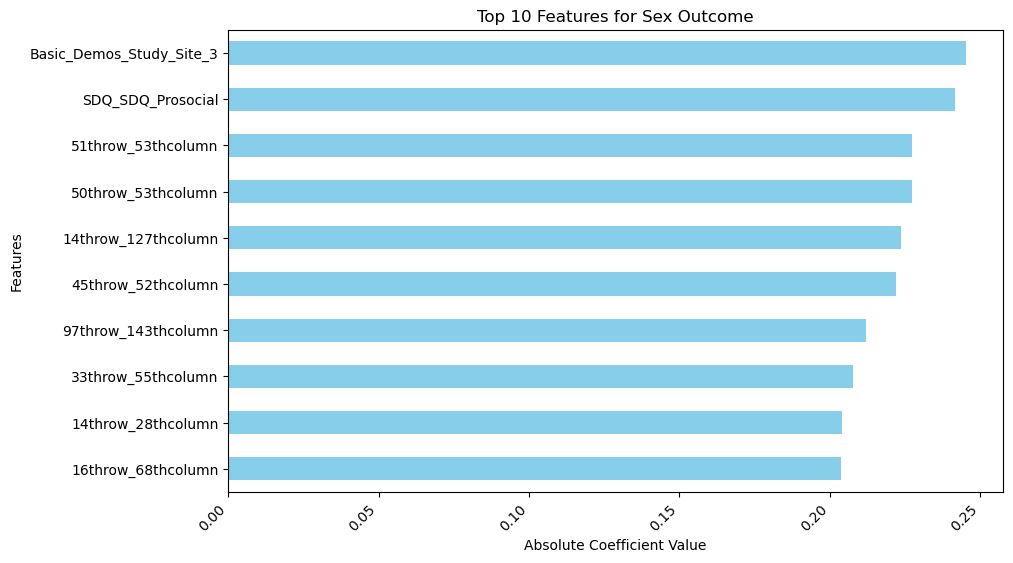

In [107]:
#Plotting the top 10 coefficents for Sex Outcome
plt.figure(figsize=(10,6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Features for Sex Outcome')
plt.ylabel('Features')
plt.xlabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.show()

In [108]:
model = LogisticRegression(max_iter=1000)
model.fit(train_df.drop(columns='participant_id'), train_Solutions['ADHD_Outcome'])

LogisticRegression(max_iter=1000)

In [109]:
# Get coefficients for ADHD_Outcome prediction
coefficients = pd.Series(model.coef_[0], index=train_df.drop(columns='participant_id').columns)

In [110]:
# Select top features for ADHD_Outcome prediction
top_features = coefficients.abs().nlargest(10)
print(top_features)

Basic_Demos_Enroll_Year_2016    0.316350
Basic_Demos_Enroll_Year_2018    0.290476
MRI_Track_Age_at_Scan           0.254161
50throw_83thcolumn              0.249752
Basic_Demos_Study_Site_3        0.241764
30throw_34thcolumn              0.229239
119throw_175thcolumn            0.225179
3throw_172thcolumn              0.219995
3throw_67thcolumn               0.217973
156throw_168thcolumn            0.213888
dtype: float64


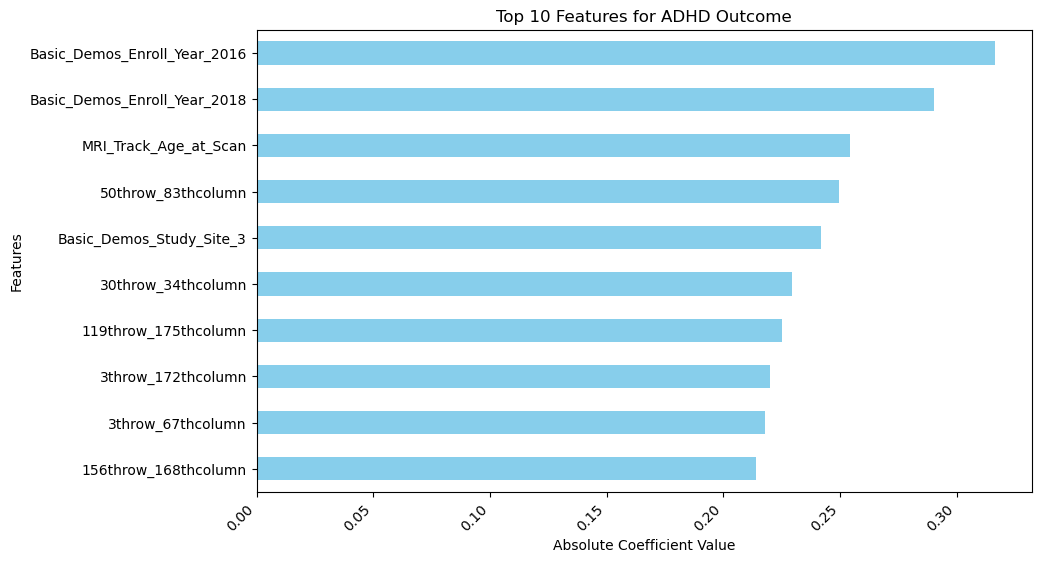

In [111]:
#Plotting the top 10 coefficents
plt.figure(figsize=(10,6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Features for ADHD Outcome')
plt.ylabel('Features')
plt.xlabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.show()

**Using L1 Regularization** Sex prediction

In [113]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(train_df.drop(columns='participant_id'), train_Solutions['Sex_F'])

LogisticRegression(penalty='l1', solver='liblinear')

In [114]:
selected_features_Sex = train_df.drop(columns='participant_id').columns[model.coef_[0] != 0]
print(selected_features_Sex)

Index(['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'Basic_Demos_Enroll_Year_2018',
       'Basic_Demos_Enroll_Year_2019', 'Basic_Demos_Study_Site_3',
       '0throw_1thcolumn', '0throw_43thcolumn',
       ...
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'],
      dtype='object', length=740)


**Using L1 Regularization** ADHD prediction

In [116]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(train_df.drop(columns='participant_id'), train_Solutions['ADHD_Outcome'])

LogisticRegression(penalty='l1', solver='liblinear')

In [117]:
selected_features_ADHD = train_df.drop(columns='participant_id').columns[model.coef_[0] != 0]
print(selected_features_ADHD)

Index(['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'Basic_Demos_Enroll_Year_2016',
       'Basic_Demos_Enroll_Year_2018', 'Basic_Demos_Enroll_Year_2019',
       ...
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'],
      dtype='object', length=698)


**Row Selection and Reduction to Improve the Model**

In [119]:
# Step 1: Find common features between ADHD and Sex selected features
common_features = list(set(selected_features_ADHD) & set(selected_features_Sex))
print('PreInt_Demos_Fam_Child_Ethnicity' in common_features)

True


In [120]:
top_20_features_list = top_20_features.index.tolist()

# Step 2: Check if each of the top 20 features is in the common_features list
for feature in top_20_features_list:
    if feature in common_features:
        print(f"{feature} is in common_features")
    else:
        print(f"{feature} is NOT in common_features")

51throw_129thcolumn is in common_features
142throw_168thcolumn is NOT in common_features
45throw_174thcolumn is NOT in common_features
50throw_83thcolumn is in common_features
138throw_183thcolumn is NOT in common_features
26throw_51thcolumn is NOT in common_features
117throw_150thcolumn is NOT in common_features
149throw_174thcolumn is NOT in common_features
47throw_174thcolumn is NOT in common_features
36throw_55thcolumn is NOT in common_features
73throw_78thcolumn is NOT in common_features
121throw_181thcolumn is NOT in common_features
44throw_174thcolumn is NOT in common_features
68throw_97thcolumn is NOT in common_features
48throw_77thcolumn is NOT in common_features
129throw_171thcolumn is NOT in common_features
45throw_173thcolumn is NOT in common_features
48throw_174thcolumn is NOT in common_features
75throw_152thcolumn is NOT in common_features
27throw_146thcolumn is in common_features


In [121]:
X_train_2 = X_train[common_features]
X_test_2 = X_test[common_features]

**Fit and Transform Model**

In [123]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize the base classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)

In [124]:
# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

In [125]:
# Train the model
multioutput_classifier.fit(X_train_2, Y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [126]:
y_pred_2 = multioutput_classifier.predict(X_test_2)

In [127]:
# Convert predictions to a DataFrame
predictions_df_2 = pd.DataFrame(
    y_pred_2,
    columns=['Predicted_Gender', 'Predicted_ADHD']
)

# Combine participant IDs with predictions
result_df_2 = pd.concat([participant_id.reset_index(drop=True), predictions_df_2], axis=1)

result_df_2.head()

,participant_id,Predicted_Gender,Predicted_ADHD
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,0,1
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,0,0


**Evaluate the Model Using Cross Validation**

In [129]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

In [130]:
# Create a scorer using scikit-learn's make_scorer
multi_output_scorer = make_scorer(multi_output_accuracy)

In [131]:
# Perform cross-validation on the training data
cv_scores_2 = cross_val_score(multioutput_classifier, X_train_2, Y_train, cv=5, scoring=multi_output_scorer, n_jobs=-1)

# Output the cross-validation results
print("Cross-validation scores for each fold:", cv_scores_2)
print("Mean CV score:", np.mean(cv_scores_2))

#Cross-validation scores for each fold: [0.78395062 0.76954733 0.70987654 0.66735537 0.43181818]
#Mean CV score: 0.6725096078631433

python(36829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Cross-validation scores for each fold: [0.71193416 0.70164609 0.71604938 0.54752066 0.28719008]
Mean CV score: 0.5928680746862565


**Using correlated features**

In [133]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize the base classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)

In [134]:
# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

In [135]:
X_train_3 = X_train[top_20_features_list]
X_test_3 = X_test[top_20_features_list]

In [136]:
# Train the model
multioutput_classifier.fit(X_train_3, Y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [137]:
y_pred_3 = multioutput_classifier.predict(X_test_3)

In [138]:
# Convert predictions to a DataFrame
predictions_df_3 = pd.DataFrame(
    y_pred_3,
    columns=['Predicted_Gender', 'Predicted_ADHD']
)

# Combine participant IDs with predictions
result_df_3 = pd.concat([participant_id.reset_index(drop=True), predictions_df_3], axis=1)

result_df_3.head()

,participant_id,Predicted_Gender,Predicted_ADHD
0,Cfwaf5FX7jWK,1,1
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,0,0
4,EnFOUv0YK1RG,1,1


In [139]:
# Create a scorer using scikit-learn's make_scorer
multi_output_scorer = make_scorer(multi_output_accuracy)

In [140]:
# Perform cross-validation on the training data
cv_scores_3 = cross_val_score(multioutput_classifier, X_train_3, Y_train, cv=5, scoring=multi_output_scorer, n_jobs=-1)

# Output the cross-validation results
print("Cross-validation scores for each fold:", cv_scores_3)
print("Mean CV score:", np.mean(cv_scores_3))

Cross-validation scores for each fold: [0.73251029 0.72839506 0.66666667 0.53099174 0.27272727]
Mean CV score: 0.5862582049450736


**Using BOTH correlated features and feature importance**

In [142]:
# Assuming common_features and top_20_features_list are already defined

# Convert both lists to sets and take the union (unique values from both)
merged_features = list(set(top_20_features_list) | set(common_features))

# Alternatively, you can use set().union() method:
# merged_features = list(set(top_20_features_list).union(common_features))

# Print the merged list
len(merged_features)


75

In [143]:
# Initialize the base classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)

In [144]:
# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

In [145]:
X_train_4 = X_train[merged_features]
X_test_4 = X_test[merged_features]

In [146]:
multioutput_classifier.fit(X_train_4, Y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [147]:
y_pred_4 = multioutput_classifier.predict(X_test_4)

In [148]:
# Convert predictions to a DataFrame
predictions_df_4 = pd.DataFrame(
    y_pred_4,
    columns=['Predicted_Gender', 'Predicted_ADHD']
)

# Combine participant IDs with predictions
result_df_4 = pd.concat([participant_id.reset_index(drop=True), predictions_df_4], axis=1)

result_df_4.head()

,participant_id,Predicted_Gender,Predicted_ADHD
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,0
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,0,0


In [149]:
# Create a scorer using scikit-learn's make_scorer
multi_output_scorer = make_scorer(multi_output_accuracy)

In [150]:
# Perform cross-validation on the training data
cv_scores_4 = cross_val_score(multioutput_classifier, X_train_4, Y_train, cv=5, scoring=multi_output_scorer, n_jobs=-1)

# Output the cross-validation results
print("Cross-validation scores for each fold:", cv_scores_4)
print("Mean CV score:", np.mean(cv_scores_4))

Cross-validation scores for each fold: [0.73868313 0.74074074 0.70987654 0.54545455 0.29338843]
Mean CV score: 0.6056286773458491


In [151]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score

# Create the custom scorer for F1 score (you can use 'macro', 'micro', or 'weighted')
f1_scorer = make_scorer(f1_score, average='weighted')  # You can change 'weighted' to 'macro' or 'micro'

# Perform cross-validation on the training data
cv_scores_4 = cross_val_score(multioutput_classifier, X_train_4, Y_train, cv=5, scoring=f1_scorer, n_jobs=-1)

# Output the cross-validation results
print("Cross-validation F1 scores for each fold:", cv_scores_4)
print("Mean CV F1 score:", np.mean(cv_scores_4))


Cross-validation F1 scores for each fold: [0.75317657 0.7588891  0.71218353 0.47482639 0.34177215]
Mean CV F1 score: 0.6081695481655741


In [152]:
import os
print(os.getcwd())

/Users/mayapatel/UCLA_WiDs_Team-21


In [153]:
result_df_4.shape

(304, 3)

In [154]:
result_df_4.to_csv('/Users/mayapatel/UCLA_WiDs_Team-21/results1.csv', index=False)